**Imports**

In [ ]:
!pip install rectools
!pip install pandas
!pip install numba
!pip install numpy

In [ ]:
import time
import timeit

import pandas as pd
import numpy as np
import numba as nb
from matplotlib import pyplot as plt

from tqdm.auto import tqdm
from rectools import Columns

In [ ]:
np.random.seed(23)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Read Data**

In [ ]:
import requests
url = 'https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_original.zip'

In [ ]:
req = requests.get(url, stream=True)

with open('kion.zip', 'wb') as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

kion dataset download:   0%|          | 0.00/78.8M [00:00<?, ?iB/s]

In [ ]:
import zipfile as zf

files = zf.ZipFile('kion.zip','r')
files.extractall()
files.close()

In [ ]:
interactions = pd.read_csv('data_original/interactions.csv')

interactions.rename(
    columns={
        'track_id': 'item_id',
        'last_watch_dt': 'datetime',
        'total_dur': 'weight'
    },
    inplace=True)

interactions['datetime'] = pd.to_datetime(interactions['datetime'])

In [ ]:
users = pd.read_csv('data_original/users.csv')
items = pd.read_csv('data_original/items.csv')

In [ ]:
def headtail(df):
    return pd.concat([df.head(), df.tail()])

headtail(interactions)

,user_id,item_id,datetime,weight,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
5476246,648596,12225,2021-08-13,76,0.0
5476247,546862,9673,2021-04-13,2308,49.0
5476248,697262,15297,2021-08-20,18307,63.0
5476249,384202,16197,2021-04-19,6203,100.0
5476250,319709,4436,2021-08-15,3921,45.0


Фукнция генерации случайной выборки

In [ ]:
def generate_subsample(users_count: int, top_k: int, data: pd.DataFrame=interactions):
    users = np.random.choice(data['user_id'].unique(), users_count, replace=False)
    df = data[data['user_id'].isin(users)].reset_index(drop=True)
    del df['datetime'], df['weight'], df['watched_pct']
    
    recs = np.random.choice(df['item_id'], size=(users_count, top_k))
    return df, users, recs

**MRR calculations**

Pandas

In [ ]:
def mrr_pandas(df_target: pd.DataFrame, users: np.ndarray, recs: np.ndarray):
    k = recs.shape[1]
    df_recs = pd.DataFrame({
        'user_id': np.repeat(users, k),
        'item_id': recs.ravel()
    })
    df_recs['rank'] = df_recs.groupby('user_id').cumcount() + 1
    df_target['target'] = 1
    df_recs = df_recs.merge(
        df_target,
        how='left',
        left_on=['user_id', 'item_id'],
        right_on=['user_id', 'item_id']
        )
    df_target.drop(['target'], axis=1, inplace=True)
    df_recs['reciprocal_rank'] = 0
    df_recs.loc[~df_recs['target'].isna(), 'reciprocal_rank'] = 1 / (df_recs.loc[~df_recs['target'].isna(), 'rank'])
    mrr = df_recs.groupby('user_id')['reciprocal_rank'].max().sum() / len(users)
    return mrr

Naive

In [ ]:
def mrr_naive(target: np.ndarray, users: np.ndarray, recs: np.ndarray):
    mrr = []
    for i, user in enumerate(users):
        user_mrr = 0.0
        user_target = target[target[:, 0] == user][:, 1]
        for j, rec in enumerate(recs[i]):
            if rec in user_target:
                user_mrr = 1 / (j + 1)
                break
        mrr.append(user_mrr)
    return sum(mrr) / len(users)

Numba

In [ ]:
@nb.njit(cache=True, parallel=True)
def mrr_numba(target: np.ndarray, users: np.ndarray, recs: np.ndarray):
    mrr = np.zeros(len(users))
    for i in nb.prange(len(users)):
        user_mrr = 0.0
        user = users[i]
        user_target = target[target[:, 0] == user][:, 1]
        for j, rec in enumerate(recs[i]):
            if rec in user_target:
                user_mrr = 1 / (j + 1)
                break
        mrr[i] = user_mrr
    return mrr.mean()

In [ ]:
for top_k in [5, 10, 15]:
    for n_users in [100, 500, 1000, 10000]:
        for _ in range(10):
            df, users, recs = generate_subsample(n_users, top_k)
            target = df.values
            naive_mrr = mrr_naive(target, users, recs)
            nb_mrr = mrr_numba(target, users, recs)
            pd_mrr = mrr_pandas(df, users, recs)
            assert np.abs(naive_mrr - pd_mrr) < 1e-6, 'pandas and naive calculations are not equal'
            assert np.abs(nb_mrr - pd_mrr) < 1e-6, 'numba and pandas calculations are not equal'
            assert np.abs(naive_mrr - nb_mrr) < 1e-6, 'naive and numba calculations are not equal'
print(f'All OK!')

All OK!


**Compare speed pandas, naive, numba**

In [ ]:
users_counts = [100, 1000, 10000, 100000]
top_ks = [10, 50, 100]
n_runs = 10

In [ ]:
time_naive = np.zeros((len(users_counts), len(top_ks)))
time_numba = np.zeros((len(users_counts), len(top_ks)))
time_pandas = np.zeros((len(users_counts), len(top_ks)))

In [ ]:
for i, user_count in enumerate(users_counts):
    for j, top_k in enumerate(top_ks):
        df, users, recs = generate_subsample(user_count, top_k)
        target = df.values
        
        print(f'Run naive user_count: {user_count}, top_k: {top_k} for {n_runs} times')
        t = timeit.timeit('mrr_naive(target, users, recs)', "from __main__ import mrr_naive, target, users, recs" , number=n_runs)
        print(f'Avg time: {t / n_runs:0.4f} seconds')
        time_naive[i][j] = t / n_runs
              
        print(f'Run numba user_count: {user_count}, top_k: {top_k} for {n_runs} times')
        t = timeit.timeit('mrr_numba(target, users, recs)', "from __main__ import mrr_numba, target, users, recs", number=n_runs)
        print(f'Avg time: {t / n_runs:0.4f} seconds')
        time_numba[i][j] = t / n_runs
               
        print(f'Run pandas user_count: {user_count}, top_k: {top_k} for {n_runs} times')
        t = timeit.timeit('mrr_pandas(df, users, recs)', "from __main__ import mrr_pandas, df, users, recs", number=n_runs)
        print(f'Avg time: {t / n_runs:0.4f} seconds')
        time_pandas[i][j] = t / n_runs

Run naive user_count: 100, top_k: 10 for 10 times
Avg time: 0.0038 seconds
Run numba user_count: 100, top_k: 10 for 10 times
Avg time: 0.0001 seconds
Run pandas user_count: 100, top_k: 10 for 10 times
Avg time: 0.0062 seconds
Run naive user_count: 100, top_k: 50 for 10 times
Avg time: 0.0105 seconds
Run numba user_count: 100, top_k: 50 for 10 times
Avg time: 0.0002 seconds
Run pandas user_count: 100, top_k: 50 for 10 times
Avg time: 0.0076 seconds
Run naive user_count: 100, top_k: 100 for 10 times
Avg time: 0.0151 seconds
Run numba user_count: 100, top_k: 100 for 10 times
Avg time: 0.0002 seconds
Run pandas user_count: 100, top_k: 100 for 10 times
Avg time: 0.0076 seconds
Run naive user_count: 1000, top_k: 10 for 10 times
Avg time: 0.0454 seconds
Run numba user_count: 1000, top_k: 10 for 10 times
Avg time: 0.0109 seconds
Run pandas user_count: 1000, top_k: 10 for 10 times
Avg time: 0.0087 seconds
Run naive user_count: 1000, top_k: 50 for 10 times
Avg time: 0.1198 seconds
Run numba user

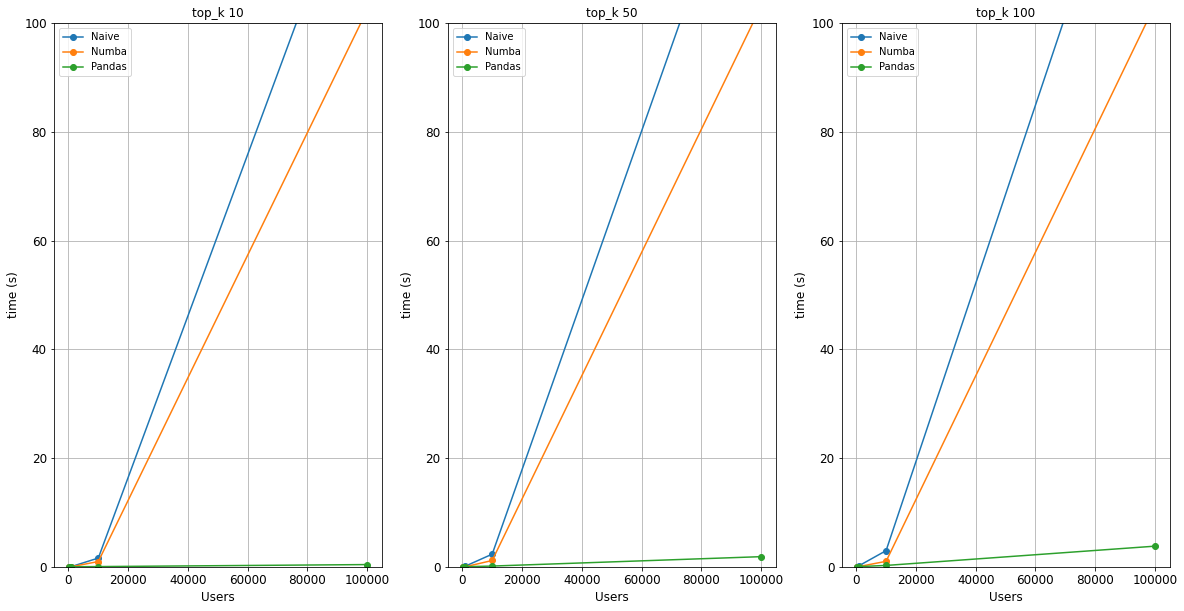

In [ ]:
_, ax = plt.subplots(1, 3, figsize=(20, 10))
for i in range(3):
    ax[i].plot(users_counts, time_naive[:, i], label='Naive', marker="o", markersize=6)
    ax[i].plot(users_counts, time_numba[:, i], label='Numba', marker="o", markersize=6)
    ax[i].plot(users_counts, time_pandas[:, i], label='Pandas', marker="o", markersize=6)
    ax[i].set_title(f'top_k {top_ks[i]}', fontsize=12)
    ax[i].set_xlabel('Users', fontsize=12)
    ax[i].set_ylabel('time (s)', fontsize=12)
    ax[i].set_ylim(0, 100)
    ax[i].tick_params(axis="both", which="major", labelsize=12)
    ax[i].grid()
    ax[i].legend()
plt.show()
